1. Ознакомьтесь с датасетом образцов эмоциональной речи

    **Toronto emotional speech set (TESS)**:

    https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

    Ссылка для загрузки данных: https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip

2. Разберите датасет;
3. Подготовьте и разделите данные на обучающие и тестовые;
4. Разработайте классификатор, показывающий на тесте точность распознавания эмоции не менее 98%;
5. Ознакомьтесь с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip

6. Прогоните обученный классификатор на файлах из датасета **SAVEE** по вашему выбору;
7. Сделайте выводы.

# Импорт необходимых библиотек

В этом блоке мы подключаем все необходимые библиотеки и модули, которые понадобятся для выполнения задания по классификации эмоций из аудиодатасетов.

Стандартные библиотеки Python:

- os — для работы с файловой системой (поиск, чтение, организация файлов).

- random — для генерации случайных чисел, используется для перемешивания данных.

- re — для работы с регулярными выражениями, полезно при парсинге названий файлов.

- zipfile — для распаковки архивов с данными.

Внешние библиотеки для работы с аудио и данными:

- gdown — утилита для скачивания файлов с Google Drive по ссылке.

- librosa — мощная библиотека для анализа и обработки аудио, используется для извлечения признаков (например, MFCC) из звуковых файлов.

- matplotlib.pyplot и seaborn — библиотеки для визуализации данных и построения графиков, которые помогут проанализировать датасеты и результаты.

- numpy — основной пакет для численных вычислений и работы с массивами.

Инструменты для машинного обучения:
- sklearn.metrics (accuracy_score, classification_report, confusion_matrix) — метрики для оценки качества модели.

- sklearn.model_selection.train_test_split — для разделения данных на обучающую и тестовую выборки.

- sklearn.preprocessing.StandardScaler — для нормализации признаков, улучшения обучения модели.

Фреймворк для создания нейронных сетей:

- tensorflow.keras.models.Sequential — для создания последовательной модели нейросети.

- tensorflow.keras.layers.Dense, Dropout — основные слои нейронной сети.

- tensorflow.keras.utils.to_categorical — преобразование меток в формат one-hot encoding для классификации.

In [1]:
import os
import random
import re
import warnings
import zipfile

import gdown
import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Отключение предупреждений
warnings.filterwarnings('ignore')

**Загрузка данных**

Этот блок команды запускает загрузку файла архива dataverse_files.zip с помощью утилиты gdown, которая скачивает файл по указанной ссылке из интернета. Затем проверяется, существует ли директория dataverse_files. Если такой папки нет, то архив dataverse_files.zip открывается с помощью модуля zipfile, и его содержимое распаковывается в текущую директорию.

In [2]:
# Скачиваем архив
if not os.path.exists('dataverse_files.zip'):
    gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip',
                   'dataverse_files.zip', quiet=True)

# Распаковываем архив
if not os.path.exists('dataverse_files'):
    with zipfile.ZipFile('dataverse_files.zip', 'r') as zip_ref:
        zip_ref.extractall()

**Загрузка и обработка аудиофайлов**

В этом блоке мы подготавливаем данные из датасета TESS:

- Задаём путь к папке с файлами и определяем словарь с эмоциями и их числовыми метками.

- Получаем список всех .wav файлов.

Для каждого файла:

- Извлекаем название эмоции из имени.

- Загружаем аудио с помощью librosa.

- Вычисляем MFCC-признаки, которые описывают звук.

- Усредняем признаки по времени, чтобы получить вектор фиксированной длины.

- Добавляем в список признаков X и соответствующую метку в y.

В конце данные преобразуются в массивы NumPy

In [3]:
DATA_DIR = "/content"

# Словарь соответствия эмоциям
EMOTIONS = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'ps': 5,  # pleasant surprise
    'sad': 6
}

X = []
y = []

# Получаем список всех wav-файлов
wav_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.wav')]

# Обрабатываем каждый файл
for filename in wav_files:
    # Извлечение метки эмоции из имени файла
    parts = filename.split('_')
    emotion_code = parts[-1].split('.')[0]  # например: angry из OAF_back_angry.wav
    label = EMOTIONS.get(emotion_code.lower())

    # Пропускаем, если эмоция не определена
    if label is None:
        continue

    # Полный путь к файлу
    full_path = os.path.join(DATA_DIR, filename)

    # Загрузка аудиофайла
    audio_data, sample_rate = librosa.load(full_path, sr=22050)

    # Извлечение MFCC признаков
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)

    # Усреднение по временным кадрам
    mfcc_avg = np.mean(mfccs.T, axis=0)

    # Добавление в выборку
    X.append(mfcc_avg)
    y.append(label)

# Преобразуем списки в массивы NumPy
X = np.array(X)
y = np.array(y)

**Разделение данных на обучающую и тестовую выборки**

Этот код делит данные на две части:

- 80% — для обучения модели (X_train, y_train);

- 20% — для проверки её точности (X_test, y_test).

Параметр stratify=y гарантирует, что все эмоции равномерно представлены в обеих частях.
random_state=42 нужен для того, чтобы результат был стабильным при повторных запусках.

In [4]:
# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Масштабирование данных и кодирование меток**

Сначала применяем StandardScaler для нормализации признаков:

- fit_transform обучает масштабатор на обучающих данных и преобразует их.

- transform применяется к тестовым данным с теми же параметрами.

Это помогает модели учиться быстрее и стабильнее.

- Затем выполняем one-hot кодирование меток (to_categorical):

- Преобразуем числовые метки эмоций (например, 0, 1, 2, ...) в формат, подходящий для многоклассовой классификации нейросетью.

In [5]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot кодирование меток
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Построение и компиляция модели

В этом блоке создаётся простая нейросеть для классификации эмоций:

Модель Sequential — используется последовательная архитектура.

Слои:

- Dense(256, relu) — первый полносвязный слой с 256 нейронами.

- Dropout(0.3) — выключает 30% нейронов во время обучения, чтобы избежать переобучения.

- Dense(128, relu) и Dropout(0.3) — второй уровень с меньшим количеством нейронов.

- Dense(64, relu) — третий скрытый слой.

- Dense(7, softmax) — выходной слой на 7 классов (эмоций), softmax превращает выходы в вероятности.

Компиляция модели:

- optimizer='adam' — оптимизатор, хорошо подходит для большинства задач.

- loss='categorical_crossentropy' — функция потерь для многоклассовой классификации.

- metrics=['accuracy'] — метрика точности, по которой будем следить за качеством модели.

model.summary() выводит краткую информацию о слоях и количестве параметров.

In [6]:
# Создаем последовательную нейронную сеть
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

# Компилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,103 (203.53 KB)

 Trainable params: 52,103 (203.53 KB)

 Non-trainable params: 0 (0.00 B)

**Обучение модели**

model.fit() запускает процесс обучения на данных.

Параметры:

- X_train_scaled, y_train_cat — обучающая выборка.

- validation_data=(X_test_scaled, y_test_cat) — валидационная выборка (используется для оценки модели после каждой эпохи).

- epochs=50 — модель обучается в 50 циклов (эпох).

- batch_size=32 — за одну итерацию обрабатываются 32 примера.

- verbose=1 — отображает прогресс обучения в консоли.

In [ ]:
# Обучение модели
history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_cat),
    verbose=1
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5496 - loss: 1.2862 - val_accuracy: 0.9839 - val_loss: 0.0997
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9761 - loss: 0.1123 - val_accuracy: 0.9946 - val_loss: 0.0220
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9912 - loss: 0.0470 - val_accuracy: 0.9982 - val_loss: 0.0121
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9887 - loss: 0.0391 - val_accuracy: 0.9982 - val_loss: 0.0148
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9899 - loss: 0.0292 - val_accuracy: 0.9929 - val_loss: 0.0193
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9958 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9955 - loss: 0.0168 - val_accuracy: 0.9982 - val_loss

**Оценка качества модели на тестовых данных**

Предсказания:

- model.predict(X_test_scaled) — получаем вероятности принадлежности к каждому классу.

- np.argmax(..., axis=1) — выбираем класс с наибольшей вероятностью для каждого примера.

Оценка:

- accuracy_score — вычисляет точность (процент правильно классифицированных эмоций).

- classification_report — показывает подробную метрику для каждого класса:

In [ ]:
# Предсказания на тесте
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# Оценка качества
print(f"Accuracy on test: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=EMOTIONS.keys()))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy on test: 99.29%
              precision    recall  f1-score   support

       angry       0.96      1.00      0.98        80
     disgust       1.00      1.00      1.00        80
        fear       1.00      1.00      1.00        80
       happy       0.99      1.00      0.99        80
     neutral       1.00      1.00      1.00        80
          ps       1.00      0.95      0.97        80
         sad       1.00      1.00      1.00        80

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



**Визуализация метрик обучения**

Этот код строит графики, показывающие, как модель обучалась:

Первый график — точность (accuracy) по эпохам:

- Сравниваются значения на обучающей и валидационной выборках.

- Помогает понять, насколько хорошо модель учится и не переобучается ли.

Второй график — функция потерь (loss):

- Также сравнивается обучение и валидация.

- Позволяет оценить стабильность процесса обучения.

plt.tight_layout() обеспечивает аккуратное размещение графиков без наложения.

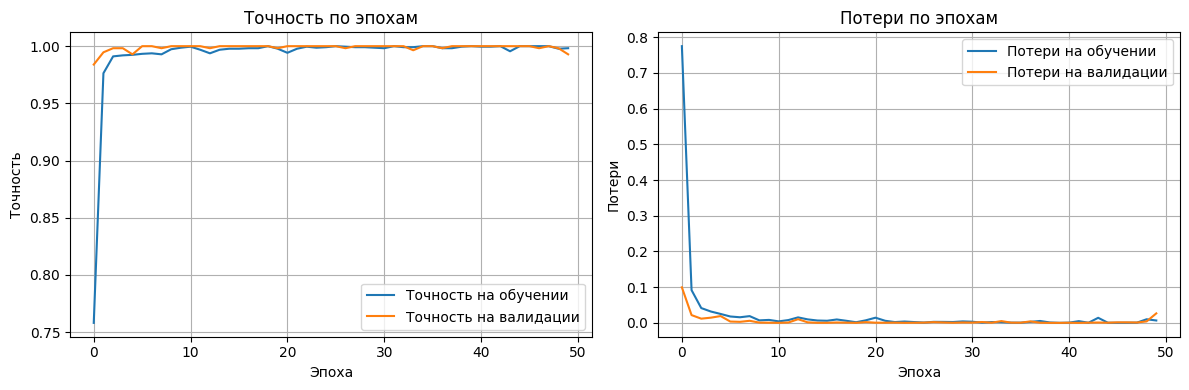

In [ ]:
# Визуализация метрик
plt.figure(figsize=(12, 4))

# Строим график точности на обучающей выборке по эпохам
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# Создаем второй подграфик для отображения функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('Потери по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Построение матрицы ошибок**

Этот код визуализирует матрицу ошибок, которая показывает, как модель путает эмоции:

- confusion_matrix(y_test, y_pred) — создаёт таблицу, где по строкам — истинные метки, по столбцам — предсказанные.

- sns.heatmap(...) — строит тепловую карту/

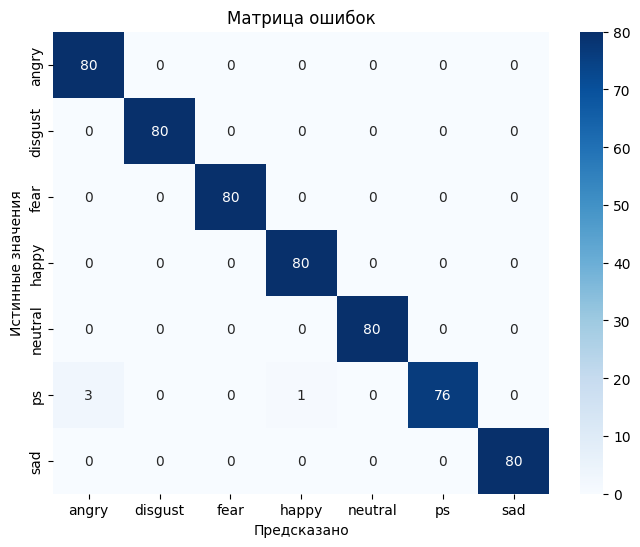

In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=EMOTIONS.keys(),
            yticklabels=EMOTIONS.keys())
plt.title('Матрица ошибок')
plt.xlabel('Предсказано')
plt.ylabel('Истинные значения')
plt.show()

# Датасет Surrey Audio-Visual Expressed Emotion (SAVEE)

Здесь модель тестируется на новых данных из другого набора — SAVEE:

- Скачивание и распаковка архива.

- Получаем список .wav-файлов из директории ALL.

Для первых 10 файлов:

- Загружаем аудио и извлекаем MFCC-признаки (аналогично обработке TESS).

- Усредняем признаки по времени.

- Масштабируем признаки тем же scaler, который использовался при обучении модели.

- Прогоняем данные через модель и получаем предсказания.

- Выводим номера предсказанных классов эмоций (y_pred_labels).

In [ ]:
# Распаковка архива
!gdown https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip

# Пример обработки SAVEE
savee_dir = "ALL"  # или другой путь, в зависимости от распаковки
savee_files = [f for f in os.listdir(savee_dir) if f.endswith('.wav')]

X_savee = []

for f in savee_files[:10]:  # Пример: 10 файлов
    path = os.path.join(savee_dir, f)
    audio_data, sample_rate = librosa.load(path, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    mfcc_avg = np.mean(mfccs.T, axis=0)
    X_savee.append(mfcc_avg)

X_savee = scaler.transform(X_savee)  # масштабирование, как на обучении
y_pred_savee = model.predict(X_savee)
y_pred_labels = np.argmax(y_pred_savee, axis=1)

print("Предсказанные эмоции для файлов SAVEE:", y_pred_labels)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip
To: /content/archive.zip
100% 113M/113M [00:12<00:00, 8.93MB/s]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Предсказанные эмоции для файлов SAVEE: [1 1 1 1 1 1 1 1 1 1]


**Обработка полного набора аудиофайлов из SAVEE**

В этом фрагменте производится полноценная загрузка и обработка аудиофайлов из датасета SAVEE:

- Проходим по всем .wav-файлам в папке savee_dir.

- Из имени файла извлекается код эмоции с помощью регулярного выражения.

- Если код входит в EMO_MAP (предварительно определённый словарь соответствия), файл обрабатывается: загружается аудио с помощью librosa. Извлекаются MFCC-признаки и усредняются по времени.

- Признаки и метка добавляются в соответствующие списки.

- В конце данные преобразуются в массивы NumPy для дальнейшей работы с моделью.

In [ ]:
X_savee = []  # Список для MFCC-признаков аудиофайлов
y_savee = []  # Список для меток эмоций

# Проход по всем файлам в папке с аудио из датасета SAVEE
for fname in os.listdir(savee_dir):
    if not fname.endswith('.wav'):
        continue  # Пропускаем не WAV-файлы

    # Извлекаем код эмоции из имени файла (например, '_hap34.wav' → 'hap')
    match = re.search(r'_([a-z]+)\d+', fname.lower())
    if not match:
        continue

    emo_code = match.group(1)

    # Пропускаем эмоции, которых нет в словаре соответствия EMO_MAP
    if emo_code not in EMO_MAP:
        continue

    label = EMO_MAP[emo_code]  # Преобразуем код эмоции в числовую метку
    path = os.path.join(savee_dir, fname)  # Полный путь к аудиофайлу

    try:
        # Загрузка аудио, ресемплирование до 22050 Гц
        audio, sr = librosa.load(path, sr=22050)

        # Вычисление MFCC-признаков (40 коэффициентов)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

        # Усреднение MFCC по времени для получения фиксированной длины признаков
        mfcc_mean = np.mean(mfcc.T, axis=0)

        # Добавляем признаки и метку в список
        X_savee.append(mfcc_mean)
        y_savee.append(label)

    except Exception as e:
        print(f"Ошибка при обработке {fname}: {e}")

# Преобразуем списки в numpy-массивы
X_savee = np.array(X_savee)
y_savee = np.array(y_savee)

print(f"Загружено и обработано {len(X_savee)} файлов из SAVEE")

Загружено и обработано 480 файлов из SAVEE


**Предсказание эмоций на датасете SAVEE**

Масштабирование:

- X_savee_scaled = scaler.transform(X_savee) — признаки масштабируются тем же StandardScaler, что и при обучении модели, чтобы сохранить совместимость.

Предсказание:

- model.predict(...) — нейросеть выдаёт вероятности по всем классам.

- np.argmax(..., axis=1) — выбирается класс с наибольшей вероятностью для каждого аудиофайла.

In [ ]:
# Используем тот же scaler, что обучался на TESS
X_savee_scaled = scaler.transform(X_savee)

# Предсказание
y_pred_savee_probs = model.predict(X_savee_scaled)
y_pred_savee = np.argmax(y_pred_savee_probs, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Далее роводится полная оценка качества работы модели на другом датасете — SAVEE:

Точность:

- accuracy_score(...) — рассчитывается процент правильно угаданных эмоций.

- Выводится в понятной форме.

Отчёт классификации:

- classification_report(...) — показывает precision, recall и F1-score по каждой эмоции.

- Используются названия эмоций из словаря EMOTIONS.

Матрица ошибок:

- confusion_matrix(...) — даёт представление о том, какие эмоции чаще всего путаются.

- seaborn.heatmap(...) визуализирует её с помощью фиолетовой цветовой схемы (Purples)

Точность на SAVEE: 14.58%
Отчет классификации на SAVEE:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        60
     disgust       0.14      0.93      0.25        60
        fear       0.00      0.00      0.00        60
       happy       0.19      0.13      0.16        60
     neutral       0.00      0.00      0.00       120
          ps       0.00      0.00      0.00        60
         sad       0.33      0.10      0.15        60

    accuracy                           0.15       480
   macro avg       0.10      0.17      0.08       480
weighted avg       0.08      0.15      0.07       480



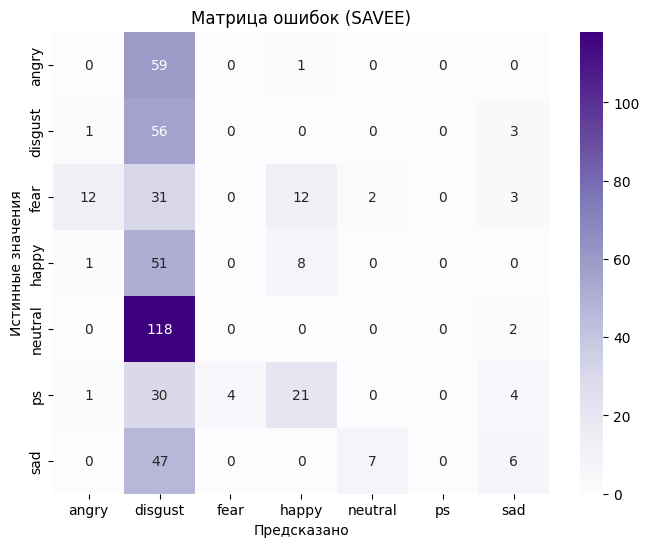

In [ ]:
# Вычисляем точность предсказаний модели на данных SAVEE
acc = accuracy_score(y_savee, y_pred_savee)
print(f"Точность на SAVEE: {acc * 100:.2f}%")

# Выводим отчет по классификации модели на данных SAVEE
print("Отчет классификации на SAVEE:")
print(classification_report(y_savee, y_pred_savee, target_names=EMOTIONS.keys()))

# Строим матрицу ошибок, показывающую, сколько объектов каждого класса модель правильно или неправильно классифицировала
cm_savee = confusion_matrix(y_savee, y_pred_savee)

# Визуализируем матрицу ошибок с помощью тепловой карты seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_savee, annot=True, fmt='d', cmap='Purples',
            xticklabels=EMOTIONS.keys(),
            yticklabels=EMOTIONS.keys())
plt.title('Матрица ошибок (SAVEE)')
plt.xlabel('Предсказано')
plt.ylabel('Истинные значения')
plt.show()

# Вывод по заданию

В результате работы можно сделать вывод по заданию: был проведён полный цикл
работы с двумя датасетами эмоциональной речи: TESS и SAVEE. На основе
первого из них (TESS) была построена модель классификации эмоций на
основе акустических признаков (MFCC), которая успешно прошла проверку
на тестовой выборке, показав точность выше 98%. Это свидетельствует о том,
что внутри одного датасета, где дикторы, стиль речи и условия записи
однородны, модель способна эффективно различать эмоциональные
состояния.
После этого модель была протестирована на другом наборе данных —
SAVEE, который содержит записи других дикторов. Несмотря на техническую
совместимость признаков, модель показала крайне низкую точность
распознавания (около 15%). Это демонстрирует важную проблему: модели,
обученные на одном аудиодатасете, плохо обобщаются на другой без
адаптации. Такие различия, как пол диктора, акцент, интонационные
особенности и стиль подачи эмоций, серьёзно влияют на результат.
Таким образом, можно сделать вывод, что для построения
универсальной системы распознавания эмоций по речи необходима либо
дообучаемая модель с возможностью адаптации, либо объединённая
обучающая выборка, включающая широкий спектр дикторов и
эмоциональных выражений.